# Band Ratios Plot

This plot compares different ways to get the exact same result in terms of the difference in BandRatios between two power spectra. 

As an example case, it uses the theta-beta ratio. 

A numerically identically change in theta / beta ratio can be obtained from:

Periodic Changes
- a change in theta power
- a change in theta bandwidth
- a change in beta center frequency
- a change in beta power
- a change in beta bandwidth

Aperiodic Changes:
- a change in aperiodic exponent

Note that for a given change (or direction of change) in TBR, there is only one CF change that could do it, in the case in which the 'baseline' PSD has oscillations entirely within band ranges. In this example, the change is a relative increase in 'theta', and there is no way to increase relative theta with CF alone, given the comparison point - but this is just inherent in the choice of comparison PSD. 

In practice, all of these changes could happen together. 

Conclusion / problem statement: given an observed change in a BandRatio measure, there is no way to tell what has actually changed. There is no reason to think the change even reflects oscillatory activity, given that aperiodic shifts can drive this effect. 

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from fooof import FOOOF
from fooof.synth import gen_power_spectrum
from fooof.plts.spectra import plot_spectrum, plot_spectra, plot_spectrum_shading, plot_spectra_shading

In [2]:
# Add band ratios code
import sys
sys.path.append('..')
from bratios.ratios import calc_band_ratio

In [3]:
# Band Settings
theta_band = [4, 8]
beta_band = [20, 30]

In [4]:
# Synthetic PSD settings
freq_range = [1, 35]
freq_res = 0.1
nlv = 0

base_ap = [0, 1.5]
base_theta = [6, 0.4, 1]
base_beta  = [25, 0.3, 2]

In [5]:
# Create a baseline PSD, with oscillations, to compare to
fs, ps_base = gen_power_spectrum(freq_range, base_ap, [base_theta, base_beta], nlv=nlv, freq_res=freq_res)

### Periodic Changes

In [6]:
# Change in center frequency
fs, ps_be_cf = gen_power_spectrum(freq_range, base_ap, [base_theta, [18.595, 0.3, 2]], nlv=nlv, freq_res=freq_res)

# Changes in oscillation power
fs, ps_th_pw = gen_power_spectrum(freq_range, base_ap, [[6, 0.557, 1], base_beta], nlv=nlv, freq_res=freq_res)
fs, ps_be_pw = gen_power_spectrum(freq_range, base_ap, [base_theta, [25, 0.106, 2]], nlv=nlv, freq_res=freq_res)

# Changes in oscillation bandwidth
fs, ps_th_bw = gen_power_spectrum(freq_range, base_ap, [[6, 0.4, 2.21], base_beta], nlv=nlv, freq_res=freq_res)
fs, ps_be_bw = gen_power_spectrum(freq_range, base_ap, [base_theta, [25, 0.3, 0.594]], nlv=nlv, freq_res=freq_res)

In [7]:
# Collect all the power spectra together
spectra_data = {'Theta Amplitude' : ps_th_pw,
                'Theta Bandwidth' :ps_th_bw,
                'Beta Frequency' : ps_be_cf,
                'Beta Amplitude' : ps_be_pw,
                'Beta Bandwidth' : ps_be_bw}

In [8]:
# Calcualte theta beta ratio of the baseline PSD
base_br = calc_band_ratio(fs, ps_base, theta_band, beta_band)

In [9]:
# Calculate delta TBRs
diffs = {}
for label, spectra in spectra_data.items():
    diffs[label] = base_br - calc_band_ratio(fs, spectra, theta_band, beta_band)

In [10]:
# Check TBR difference measures
for label, diff in diffs.items():
    print('TBR difference from   {:20}   is \t {:1.3f}'.format(label, diff))

TBR difference from   Theta Amplitude        is 	 -3.007
TBR difference from   Theta Bandwidth        is 	 -3.003
TBR difference from   Beta Frequency         is 	 -3.005
TBR difference from   Beta Amplitude         is 	 -3.001
TBR difference from   Beta Bandwidth         is 	 -3.000


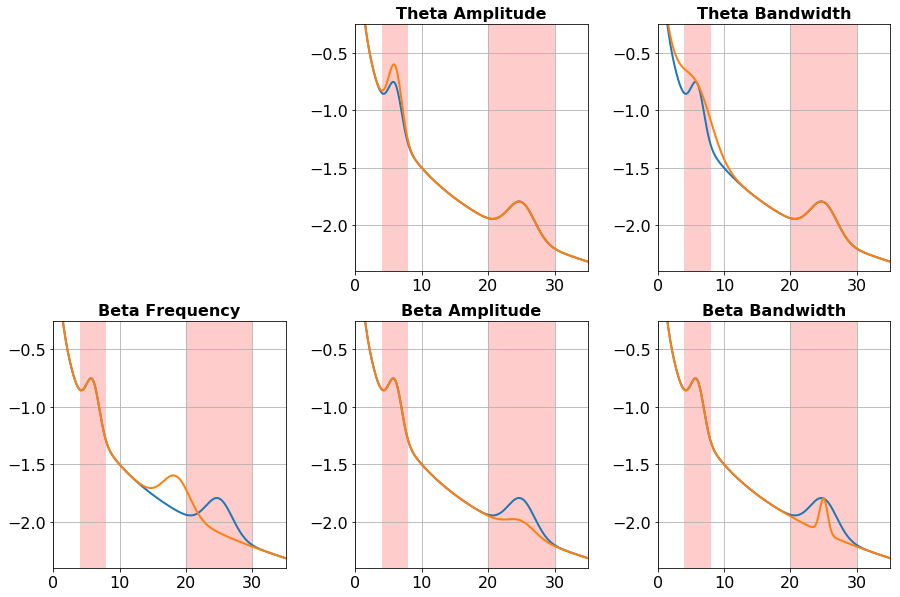

In [11]:
# Create figure
title_settings = {'fontsize': 16, 'fontweight': 'bold'}
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0, 0].axis('off')

for axis, (title, data) in zip(ax.flatten()[1:], spectra_data.items()):
    
    plot_spectra_shading(fs, [ps_base, data], [theta_band, beta_band],
                         log_freqs=False, log_powers=True, ax=axis)
    
    axis.set_title(title, **title_settings)
    
    axis.set_xlim([0, 35])
    axis.set_ylim([-2.4, -0.25])

    axis.xaxis.label.set_visible(False)
    axis.yaxis.label.set_visible(False)
    
fig.subplots_adjust(hspace=.2)
fig.subplots_adjust(wspace=.3)

plt.savefig('../figures/Periodic-Underdetermined.png', dpi=700)

### Aperiodic Changes

The same change in ratio can also be driven from changes in aperiodic properties. 

This can happen with or without oscillations even being present.

In [12]:
# Change in aperiodic slope (note: due to current fooof.synth, this also alters offset, to change rotation point)
fs, ps_ap_ex = gen_power_spectrum(freq_range, [0.2, 1.6635], [base_theta, base_beta], nlv=nlv, freq_res=freq_res)

In [13]:
# Use a new base and transformation, without any oscillations
fs, ps_new_base = gen_power_spectrum(freq_range, base_ap, [], nlv=nlv, freq_res=freq_res)
fs, ps_new_apch = gen_power_spectrum(freq_range, [0.2, 1.693], [], nlv=nlv, freq_res=freq_res)

In [14]:
# Calculate the differences in ratio from baseline spectra
d_ap_osc = base_br - calc_band_ratio(fs, ps_ap_ex, theta_band, beta_band)
d_ap_no_osc = calc_band_ratio(fs, ps_new_base, theta_band, beta_band) - \
              calc_band_ratio(fs, ps_new_apch, theta_band, beta_band)
print(d_ap_osc)
print(d_ap_no_osc)

-3.0065922833709937
-3.0023449117779126


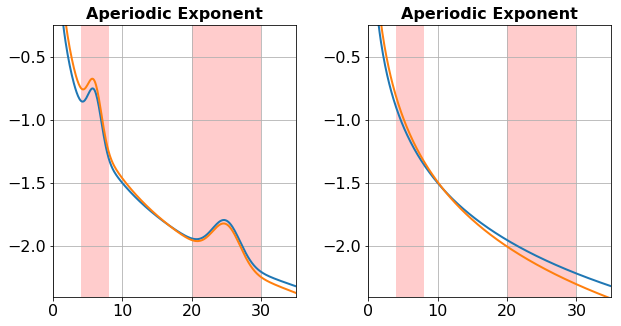

In [15]:
# Create aperiodic differences figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plot_spectra_shading(fs, [ps_base, ps_ap_ex], [theta_band, beta_band],
                     log_freqs=False, log_powers=True, ax=ax[0])
ax[0].set_title('Aperiodic Exponent', **title_settings)
plot_spectra_shading(fs, [ps_new_base, ps_new_apch], [theta_band, beta_band],
                     log_freqs=False, log_powers=True, ax=ax[1])
ax[1].set_title('Aperiodic Exponent', **title_settings)
    
for axis in ax.flatten():
    
    axis.set_xlim([0, 35])
    axis.set_ylim([-2.4, -0.25])

    axis.xaxis.label.set_visible(False)
    axis.yaxis.label.set_visible(False)
    
fig.subplots_adjust(wspace=.3)

plt.savefig('../figures/Aperiodic-Underdetermined.png', dpi=700)